In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 87% 129M/149M [00:00<00:00, 259MB/s]
100% 149M/149M [00:00<00:00, 260MB/s]


In [3]:
!pip install livelossplot

In [4]:
import zipfile
zip_ref=zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
import livelossplot

In [65]:
from keras.utils import to_categorical
import numpy as np

# Assuming train_dataset and validation_dataset are already defined
# Load datasets without any label modification
train_dataset = keras.utils.image_dataset_from_directory(
    directory='/content/Training',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

validation_dataset = keras.utils.image_dataset_from_directory(
    directory='/content/Testing',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

# Modify the datasets to include one-hot encoding for labels
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=4)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=4)))


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [66]:
#TO KEEP VALUES FROM 0 TO 1 FOR BETTER NEURAL NETWORK
def div(image,label):
  image=tf.cast(image/255.0,tf.float32)
  return image,label
train_dataset=train_dataset.map(div)
validation_dataset=validation_dataset.map(div)

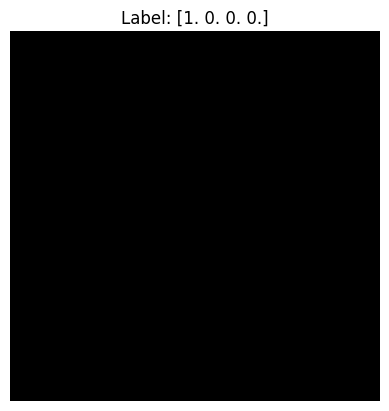

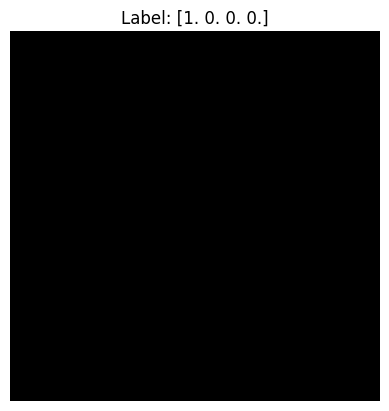

In [67]:
import matplotlib.pyplot as plt

# Assuming train_dataset is already defined
# Take the first batch from the dataset
for images, labels in train_dataset.take(2):
    # Display one image from the batch
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f"Label: {labels[0].numpy()}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

# MODEL BUILDINNG

In [56]:
import os
from keras.models import Model
from keras.optimizers import Adam,RMSprop,Adamax,Adagrad
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model

In [68]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224


vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    def lw(bottom_model, num_classes):
     top_model = bottom_model.output
     top_model = GlobalAveragePooling2D()(top_model)
     top_model = Dense(1024,activation='relu')(top_model)
     top_model = Dense(1024,activation='relu')(top_model)
     top_model = Dense(512,activation='relu')(top_model)
     top_model = Dense(num_classes,activation='softmax')(top_model)
     return top_model

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [69]:
num_classes = 4

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [70]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss for early stopping
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
model.compile(optimizer=Adamax(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist=model.fit(train_dataset,
               epochs=50,
               validation_data=validation_dataset,
               batch_size=16,
               verbose=1,
               initial_epoch=0,
              callbacks=[early_stopping])

Epoch 1/50
179/179 [==============================] - 28s 148ms/step - loss: 0.7312 - accuracy: 0.7097 - val_loss: 0.5477 - val_accuracy: 0.7994
Epoch 2/50
179/179 [==============================] - 27s 149ms/step - loss: 0.3748 - accuracy: 0.8659 - val_loss: 0.4484 - val_accuracy: 0.8307
Epoch 3/50
179/179 [==============================] - 27s 152ms/step - loss: 0.3264 - accuracy: 0.8782 - val_loss: 0.4002 - val_accuracy: 0.8642
Epoch 4/50
179/179 [==============================] - 32s 179ms/step - loss: 0.2995 - accuracy: 0.8885 - val_loss: 0.3581 - val_accuracy: 0.8627
Epoch 5/50
179/179 [==============================] - 27s 152ms/step - loss: 0.2695 - accuracy: 0.8990 - val_loss: 0.3670 - val_accuracy: 0.8558
Epoch 6/50
179/179 [==============================] - 32s 180ms/step - loss: 0.2509 - accuracy: 0.9077 - val_loss: 0.3110 - val_accuracy: 0.8825
Epoch 7/50
179/179 [==============================] - 33s 180ms/step - loss: 0.2324 - accuracy: 0.9188 - val_loss: 0.2857 - val_ac

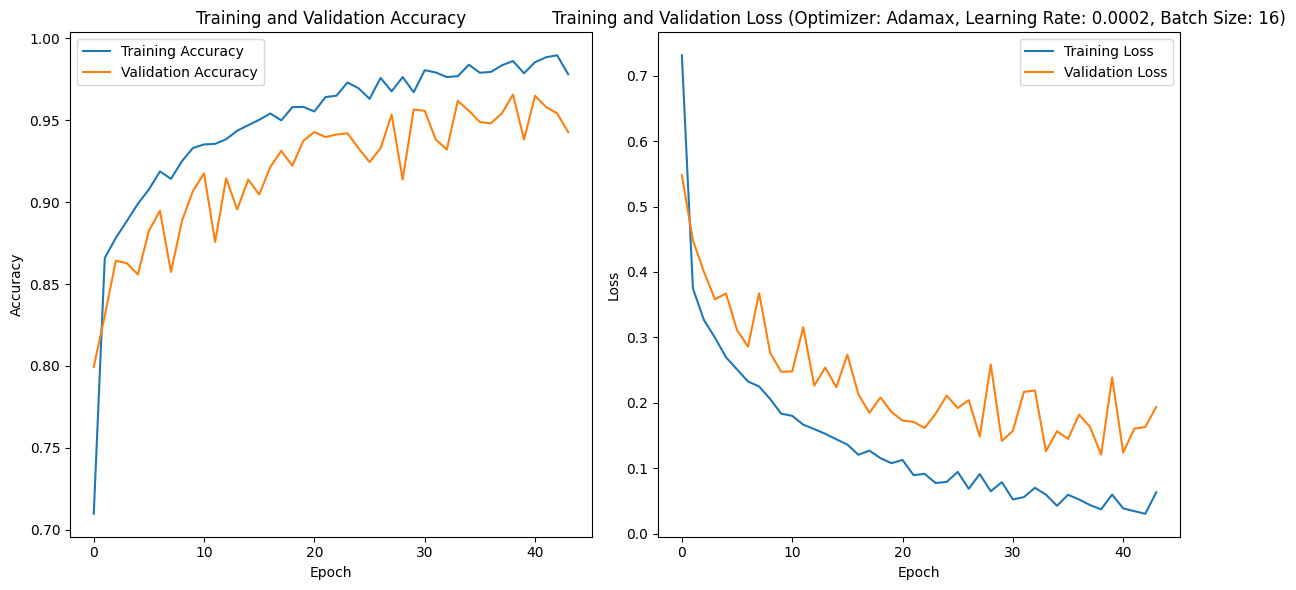

In [71]:
import matplotlib.pyplot as plt

# Assuming hist is your training history object

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Optimizer: Adamax, Learning Rate: 0.0002, Batch Size: 16)')  # Adjust the optimizer details
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.yticks([i/5 for i in range(5)])  # Set y-axis ticks with a gap of 0.2 for the loss plot

plt.tight_layout()
plt.show()
